## Project 3 Team 7

### Jasmine Sanders, Vincent Chen, and Diana Casanova

Which business establishments should the City of Chicago's Department of Public Health prioritize for food inspection safety audits? 

Ensuring food safety is a top priority for Department of Public Health but it is cost prohibitive to conduct regular inspections of every business establishment. To tackle this issue, we develop an algorithm to predict whether a business will pass or fail a food inspection using data that includes business characteristics, previous inspection results, and neighborhood characteristics. Our algorithm will help local governments identify which establishments to prioritze for inspection and improve food safety citywide. 

We start with importing our libraries and data:

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [2]:
# Inspections Data 2011 - 2013
chicago_inspections_2011_to_2013 = pd.read_csv("Chicago Inspections 2011-2013.csv")

# Inspections Data 2014
chicago_inspections_2014 = pd.read_csv("Chicago Inspections 2014.csv")

## Exploratory Data Analysis 

In this section we explore the data to familiarize ourselves with the features. This allows us to quickly identify features that are important to drop from the dataset (e.g., pass and fail flags that would perfectly predict the outcome).

In [3]:
# Look at the inspections data
chicago_inspections_2011_to_2013.head()

Inspection_ID Inspection_Date                      DBA_Name  \
0         269961      2013-01-31                    SEVEN STAR   
1         507211      2011-10-18                  PANERA BREAD   
2         507212      2011-10-18      LITTLE QUIAPO RESTAURANT   
3         507216      2011-10-19  SERGIO'S TAQUERIA PIZZA INC.   
4         507219      2011-10-20         TARGET STORE # T-2079   

                   AKA_Name  License  Facility_Type             Risk  \
0                SEVEN STAR    30790  Grocery Store     Risk 3 (Low)   
1              PANERA BREAD  1475890     Restaurant    Risk 1 (High)   
2  LITTLE QUIAPO RESTAURANT  1740130     Restaurant    Risk 1 (High)   
3   SERGIO'S TAQUERIA PIZZA  1447363     Restaurant    Risk 1 (High)   
4                    TARGET  1679459     Restaurant  Risk 2 (Medium)   

                 Address     City State      Zip Inspection_Type Results  \
0       3352 N BROADWAY   CHICAGO    IL  60657.0         Canvass    Pass   
1    6059 N LINCOLN AVE   CHICAGO    IL  60659.0         Canvass    Pass   
2   6259 N MCCORMICK RD   CHICAGO    IL  60659.0         Canvass    Fail   
3  3253 W BRYN MAWR AVE   CHICAGO    IL  60659.0         Canvass    Pass   
4   2112 W PETERSON AVE   CHICAGO    IL  60659.0         Canvass    Fail   

    Latitude  Longitude                                  Location  \
0  41.943359 -87.644999  (41.943359344775146, -87.64499875300952)   
1  41.991919 -87.709631   (41.99191947239194, -87.70963133440333)   
2  41.995632 -87.712707   (41.99563177556418, -87.71270678169132)   
3  41.982933 -87.710982  (41.982933189164974, -87.71098225381141)   
4  41.990729 -87.682979   (41.99072921796059, -87.68297945359863)   

  Facility_Type_Clean  criticalCount  seriousCount  minorCount  pass_flag  \
0               Other              0             0           2          1   
1          Restaurant              0             0           3          1   
2          Restaurant              0             2           6          0   
3          Restaurant              0             0           6          1   
4          Restaurant              0             2           6          0   

   fail_flag  pastFail  pastCritical  pastSerious  pastMinor  timeSinceLast  \
0          0         0             0            0          0            2.0   
1          0         0             0            0          0            2.0   
2          1         0             0            0          0            2.0   
3          0         0             0            0          0            2.0   
4          1         0             0            0          0            2.0   

   firstRecord                ID  LICENSE_ID  ACCOUNT_NUMBER  \
0            1    30790-20110416   2081412.0         63759.0   
1            1  1475890-20110416   2081695.0        207283.0   
2            1  1740130-20110216   2070145.0          3107.0   
3            1  1447363-20110216   2071895.0        270993.0   
4            1  1679459-20100216   2009972.0         15538.0   

                     LEGAL_NAME        DOING_BUSINESS_AS_NAME  \
0            VIRGINIA DELA ROSA                    SEVEN STAR   
1                   PANERA, LLC                  PANERA BREAD   
2                ENELITA GARCIA      LITTLE QUIAPO RESTAURANT   
3  SERGIO'S TAZUERIA PIZZA INC.  SERGIO'S TAQUERIA PIZZA INC.   
4            TARGET CORPORATION         TARGET STORE # T-2079   

                 ADDRESS     CITY STATE  ZIP_CODE  WARD  PRECINCT  \
0    3352 N BROADWAY   1  CHICAGO    IL   60657.0  44.0      33.0   
1  6059 N LINCOLN AVE  C  CHICAGO    IL   60659.0  50.0      23.0   
2    6259 N MCCORMICK RD  CHICAGO    IL   60659.0  50.0      25.0   
3   3253 W BRYN MAWR AVE  CHICAGO    IL   60659.0  39.0      48.0   
4    2112 W PETERSON AVE  CHICAGO    IL   60659.0  40.0      18.0   

  WARD_PRECINCT  POLICE_DISTRICT  LICENSE_CODE        LICENSE_DESCRIPTION  \
0         44-33             19.0        1006.0  Retail Food Establishment   
1         50-23   

In [4]:
# List column names
chicago_inspections_2011_to_2013.columns

Index(['Inspection_ID', 'Inspection_Date', 'DBA_Name', 'AKA_Name', 'License',
       'Facility_Type', 'Risk', 'Address', 'City', 'State', 'Zip',
       'Inspection_Type', 'Results', 'Latitude', 'Longitude', 'Location',
       'Facility_Type_Clean', 'criticalCount', 'seriousCount', 'minorCount',
       'pass_flag', 'fail_flag', 'pastFail', 'pastCritical', 'pastSerious',
       'pastMinor', 'timeSinceLast', 'firstRecord', 'ID', 'LICENSE_ID',
       'ACCOUNT_NUMBER', 'LEGAL_NAME', 'DOING_BUSINESS_AS_NAME', 'ADDRESS',
       'CITY', 'STATE', 'ZIP_CODE', 'WARD', 'PRECINCT', 'WARD_PRECINCT',
       'POLICE_DISTRICT', 'LICENSE_CODE', 'LICENSE_DESCRIPTION',
       'BUSINESS_ACTIVITY_ID', 'BUSINESS_ACTIVITY', 'LICENSE_NUMBER',
       'APPLICATION_TYPE', 'LICENSE_TERM_START_DATE',
       'LICENSE_TERM_EXPIRATION_DATE', 'LICENSE_STATUS', 'LATITUDE',
       'LONGITUDE', 'minDate', 'maxDate', 'ageAtInspection',
       'consumption_on_premises_incidental_activity', 'tobacco',
       'package_goods',

In [5]:
# Drop column names related to geography, identification, and pass/fail flags that perfectly predict the outcome
dropped_columns = ['AKA_Name', 
                                                 'License',
                                                'Address',
                                                'City',
                                                'State',
                                                'Zip',
                                                'Latitude',
                                                'Longitude',
                                                'Location',
                                                'ID',
                                                'LICENSE_ID',
                                                 'LICENSE_TERM_START_DATE',
                                                 'LICENSE_TERM_EXPIRATION_DATE',
                                                 'LICENSE_STATUS',
                                                'ACCOUNT_NUMBER',
                                                'LEGAL_NAME',
                                                'DOING_BUSINESS_AS_NAME',
                                                'ADDRESS',
                                                'CITY',
                                                'STATE',
                                                'ZIP_CODE',
                                                'WARD',
                                                'PRECINCT',
                                                'LICENSE_CODE',
                                                'BUSINESS_ACTIVITY_ID',
                                                'BUSINESS_ACTIVITY',
                                                'LICENSE_NUMBER',
                                                'LATITUDE',
                                                'LONGITUDE',
                                                'pass_flag',
                                                'fail_flag']
chicago_inspections_2011_to_2013.drop(columns = dropped_columns, inplace = True)
chicago_inspections_2014.drop(columns = dropped_columns, inplace = True)

chicago_inspections_2011_to_2013.set_index(['Inspection_ID', 'DBA_Name'], inplace = True)

In [6]:
# Convert the Inspection Date to a datetime format
chicago_inspections_2011_to_2013['Inspection_Date'] = pd.to_datetime(chicago_inspections_2011_to_2013['Inspection_Date'], infer_datetime_format=True)
chicago_inspections_2014['Inspection_Date'] = pd.to_datetime(chicago_inspections_2014['Inspection_Date'], infer_datetime_format=True)

## Visualization

**Inspections Over Time**: Below we plot the number of inspections over a span of two years. We can see that inspections tend to be higher in the spring and the fall, with the count of inspection increasing over time.  

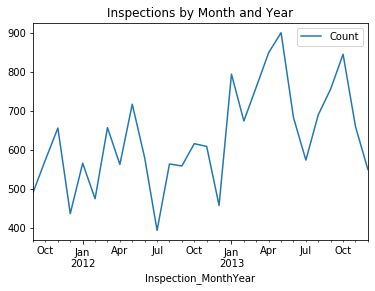

In [7]:
# Visualize Inspections Over Time
chicago_inspections_2011_to_2013['Inspection_MonthYear'] = chicago_inspections_2011_to_2013['Inspection_Date'].dt.to_period('M')
counts_by_day = chicago_inspections_2011_to_2013.groupby('Inspection_MonthYear').count().rename(columns = {'Facility_Type': 'Count'})['Count'].reset_index()
counts_by_day.set_index(["Inspection_MonthYear"], inplace = True)
counts_by_day.plot(title = "Inspections by Month and Year")

**Results:** The bar chart below shows that the majority of business establishments pass or pass with conditions. We can also see that about a quarter of the businesses fail their inspection, which underscores the need to develop a model to predict and priortize food inspection audits. Random audits would likely not be a cost-efficient or productive. Rather, identifying a model that predicts whether an establishment passes or fails an inspection will allow the city to target their resources and increase their impact on improving food safety. 

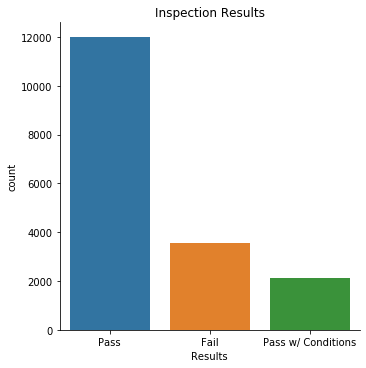

In [8]:
# Inspection Results
sns.catplot(data = chicago_inspections_2011_to_2013,
           x = "Results",
           kind = "count")

plt.title("Inspection Results")
plt.show()

**Results by Facility Type:** Below we see that our data largely consists of restaurants and that these establishments account for the majority of the "pass" and "fail" results. 

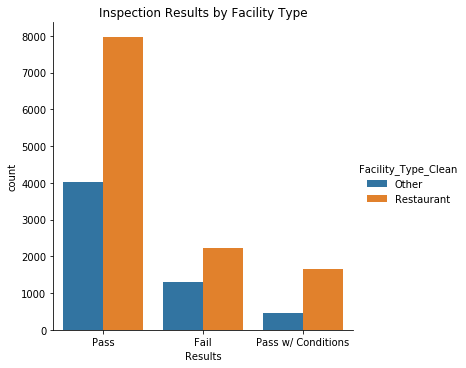

In [9]:
# Inspection Results by Facility Type (Restaurant or Not)
sns.catplot(data = chicago_inspections_2011_to_2013,
           x = "Results",
           kind = "count",
           hue = 'Facility_Type_Clean')

plt.title("Inspection Results by Facility Type")
plt.show()

## Preprocess Data

In [10]:
# Drop datetime info
chicago_inspections_2011_to_2013 = chicago_inspections_2011_to_2013.dropna().drop(['Inspection_Date',
                                      'minDate',
                                      'maxDate',
                                      'Inspection_MonthYear'],
                                      axis = 1)
X_unseen_inspection_ids = chicago_inspections_2014['Inspection_ID']
chicago_inspections_2014 = chicago_inspections_2014.dropna().drop(['Inspection_Date',
                                      'minDate',
                                      'maxDate',],
                                      axis = 1)

In [11]:
# Set target variable. 
y = chicago_inspections_2011_to_2013['Results']
## Comment out the following code if you don't want to binarize the target variable
y = y.replace({'Pass w/ Conditions': 'Pass'})
lb_style = LabelBinarizer()
y = lb_style.fit_transform(y)
# Recode 0s and 1s so 1s are "Fail"
y = np.where(y == 1, 0 ,1)

# All other features in X
X = chicago_inspections_2011_to_2013.drop(columns = ['Results'])
X = pd.get_dummies(X)

# All features for unseen X
X_unseen = pd.get_dummies(chicago_inspections_2014)

In [12]:
X.head()

criticalCount  seriousCount  \
Inspection_ID DBA_Name                                                    
269961        SEVEN STAR                                0             0   
507211        PANERA BREAD                              0             0   
507212        LITTLE QUIAPO RESTAURANT                  0             2   
507216        SERGIO'S TAQUERIA PIZZA INC.              0             0   
507219        TARGET STORE # T-2079                     0             2   

                                            minorCount  pastFail  \
Inspection_ID DBA_Name                                             
269961        SEVEN STAR                             2         0   
507211        PANERA BREAD                           3         0   
507212        LITTLE QUIAPO RESTAURANT               6         0   
507216        SERGIO'S TAQUERIA PIZZA INC.           6         0   
507219        TARGET STORE # T-2079                  6         0   

                                            pastCritical  pastSerious  \
Inspection_ID DBA_Name                                                  
269961        SEVEN STAR                               0            0   
507211        PANERA BREAD                             0            0   
507212        LITTLE QUIAPO RESTAURANT                 0            0   
507216        SERGIO'S TAQUERIA PIZZA INC.             0            0   
507219        TARGET STORE # T-2079                    0            0   

                                            pastMinor  timeSinceLast  \
Inspection_ID DBA_Name                                                 
269961        SEVEN STAR                            0            2.0   
507211        PANERA BREAD                          0            2.0   
507212        LITTLE QUIAPO RESTAURANT              0            2.0   
507216        SERGIO'S TAQUERIA PIZZA INC.          0            2.0   
507219        TARGET STORE # T-2079                 0            2.0   

                                            firstRecord  POLICE_DISTRICT  \
Inspection_ID DBA_Name                                                     
269961        SEVEN STAR                              1             19.0   
507211        PANERA BREAD                            1             24.0   
507212        LITTLE QUIAPO RESTAURANT                1             17.0   
507216        SERGIO'S TAQUERIA PIZZA INC.            1             17.0   
507219        TARGET STORE # T-2079                   1             24.0   

                                            ageAtInspection  \
Inspection_ID DBA_Name                                        
269961        SEVEN STAR                          10.964384   
507211        PANERA BREAD                         7.457534   
507212        LITTLE QUIAPO RESTAURANT             4.578082   
507216        SERGIO'S TAQUERIA PIZZA INC.         7.805479   
507219        TARGET STORE # T-2079                5.290411   

                                            consumption_on_premises_incidental_activity  \
Inspection_ID DBA_Name                                                                    
269961        SEVEN STAR                                                              0   
507211        PANERA BREAD                                                            0   
507212        LITTLE QUIAPO RESTAURANT                                                0   
507216        SERGIO'S TAQUERIA PIZZA INC.                                            0   
507219        TARGET STORE # T-2079                                                   0   

                                            tobacco  package_goods  \
Inspection_ID DBA_Name                                               
269961        SEVEN STAR                          1              0   
507211        PANERA BREAD                        0              0   
507212        LITTLE QUIAPO RESTAURANT            0              0   
507216        SERGIO'S TAQUERIA PIZZA INC.        0          

## Feature Selection

In this section we consider feature covariance and correlation seeking to remove features that are highly correlated with one another. In part, this is because we are not gaining any additional information from a feature that is highly correlated with another feature. It is also a way of simplifying the model, which is less likely to overfit our data. 

In [13]:
X.cov(min_periods=1) #min number of observation per column to get results

criticalCount  seriousCount  minorCount  \
criticalCount                           0.309006      0.090056    0.200689   
seriousCount                            0.090056      0.462727    0.268349   
minorCount                              0.200689      0.268349    4.057448   
pastFail                                0.002445      0.008897    0.022906   
pastCritical                            0.013432      0.012265    0.027940   
...                                          ...           ...         ...   
LICENSE_DESCRIPTION_Wrigley Field       0.000400     -0.000323   -0.003617   
APPLICATION_TYPE_C_EXPA                 0.000202      0.000186    0.001391   
APPLICATION_TYPE_C_LOC                 -0.000132      0.000138   -0.000161   
APPLICATION_TYPE_ISSUE                  0.004653      0.004352   -0.014859   
APPLICATION_TYPE_RENEW                 -0.004723     -0.004676    0.013629   

                                   pastFail  pastCritical  pastSerious  \
criticalCount                      0.002445      0.013432     0.006944   
seriousCount                       0.008897      0.012265     0.019700   
minorCount                         0.022906      0.027940     0.042114   
pastFail                           0.067804      0.025982     0.085993   
pastCritical                       0.025982      0.127073     0.047555   
...                                     ...           ...          ...   
LICENSE_DESCRIPTION_Wrigley Field -0.000054      0.000468     0.000061   
APPLICATION_TYPE_C_EXPA           -0.000096     -0.000096    -0.000160   
APPLICATION_TYPE_C_LOC            -0.000041     -0.000173    -0.000223   
APPLICATION_TYPE_ISSUE            -0.005444     -0.006000    -0.009132   
APPLICATION_TYPE_RENEW             0.005581      0.006268     0.009516   

                                   pastMinor  timeSinceLast  firstRecord  \
criticalCount                       0.005870       0.010038     0.008139   
seriousCount                       -0.003594       0.023880     0.019202   
minorCount                          0.297686       0.050741     0.046156   
pastFail                            0.215851      -0.047416    -0.045156   
pastCritical                        0.259755      -0.044239    -0.045317   
...                                      ...            ...          ...   
LICENSE_DESCRIPTION_Wrigley Field  -0.001534      -0.000128    -0.000094   
APPLICATION_TYPE_C_EXPA            -0.001906       0.000530     0.000500   
APPLICATION_TYPE_C_LOC             -0.002125       0.000170     0.000377   
APPLICATION_TYPE_ISSUE             -0.113757       0.025780     0.027942   
APPLICATION_TYPE_RENEW              0.117789      -0.026480    -0.028820   

                                   POLICE_DISTRICT  ageAtInspection  \
criticalCount                             0.220934        -0.062516   
seriousCount                              0.171931        -0.076371   
minorCount                                0.805064         0.270983   
pastFail                                  0.036488         0.060970   
pastCritical                              0.105556         0.056752   
...                                            ...              ...   
LICENSE_DESCRIPTION_Wrigley Field         0.009567        -0.001656   
APPLICATION_TYPE_C_EXPA                   0.001775        -0.007619   
APPLICATION_TYPE_C_LOC                   -0.002749        -0.013612   
APPLICATION_TYPE_ISSUE                    0.045972        -0.710770   
APPLICATION_TYPE_RENEW                   -0.044998         0.732001   

                                   consumption_on_premises_incidental_activity  \
criticalCount                                                         0.009652   
seriousCount                                                          0.005137   
minorCount                                                            0.042702   
pastFail                                                              0.002325   
pastCritical                     

In [14]:
X.corr(method='pearson', min_periods=1)

criticalCount  seriousCount  minorCount  \
criticalCount                           1.000000      0.238158    0.179231   
seriousCount                            0.238158      1.000000    0.195845   
minorCount                              0.179231      0.195845    1.000000   
pastFail                                0.016889      0.050228    0.043672   
pastCritical                            0.067786      0.050581    0.038911   
...                                          ...           ...         ...   
LICENSE_DESCRIPTION_Wrigley Field       0.017813     -0.011763   -0.044474   
APPLICATION_TYPE_C_EXPA                 0.010075      0.007558    0.019120   
APPLICATION_TYPE_C_LOC                 -0.004914      0.004198   -0.001649   
APPLICATION_TYPE_ISSUE                  0.025127      0.019207   -0.022146   
APPLICATION_TYPE_RENEW                 -0.025199     -0.020389    0.020068   

                                   pastFail  pastCritical  pastSerious  \
criticalCount                      0.016889      0.067786     0.029311   
seriousCount                       0.050228      0.050581     0.067957   
minorCount                         0.043672      0.038911     0.049060   
pastFail                           1.000000      0.279907     0.774943   
pastCritical                       0.279907      1.000000     0.313040   
...                                     ...           ...          ...   
LICENSE_DESCRIPTION_Wrigley Field -0.005149      0.032514     0.003538   
APPLICATION_TYPE_C_EXPA           -0.010160     -0.007448    -0.010415   
APPLICATION_TYPE_C_LOC            -0.003280     -0.009998    -0.010816   
APPLICATION_TYPE_ISSUE            -0.062768     -0.050530    -0.064336   
APPLICATION_TYPE_RENEW             0.063574      0.052157     0.066233   

                                   pastMinor  timeSinceLast  firstRecord  \
criticalCount                       0.004722       0.031707     0.030121   
seriousCount                       -0.002362       0.061639     0.058075   
minorCount                          0.066078       0.044231     0.047141   
pastFail                            0.370640      -0.319734    -0.356773   
pastCritical                        0.325807      -0.217906    -0.261541   
...                                      ...            ...          ...   
LICENSE_DESCRIPTION_Wrigley Field  -0.016983      -0.005579    -0.004765   
APPLICATION_TYPE_C_EXPA            -0.023597       0.025751     0.028478   
APPLICATION_TYPE_C_LOC             -0.019616       0.006164     0.016032   
APPLICATION_TYPE_ISSUE             -0.152699       0.135900     0.172582   
APPLICATION_TYPE_RENEW              0.156211      -0.137911    -0.175863   

                                   POLICE_DISTRICT  ageAtInspection  \
criticalCount                             0.055414        -0.030556   
seriousCount                              0.035240        -0.030504   
minorCount                                0.055725         0.036552   
pastFail                                  0.019537         0.063618   
pastCritical                              0.041286         0.043256   
...                                            ...              ...   
LICENSE_DESCRIPTION_Wrigley Field         0.033035        -0.011144   
APPLICATION_TYPE_C_EXPA                   0.006851        -0.057315   
APPLICATION_TYPE_C_LOC                   -0.007914        -0.076359   
APPLICATION_TYPE_ISSUE                    0.019243        -0.579766   
APPLICATION_TYPE_RENEW                   -0.018609         0.589911   

                                   consumption_on_premises_incidental_activity  \
criticalCount                                                         0.054873   
seriousCount                                                          0.023863   
minorCount                                                            0.066994   
pastFail                                                              0.028218   
pastCritical                     

In [15]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
X.drop(to_drop, axis=1, inplace=True)

In [16]:
# keep only the columns used in X
X_unseen = X[X.columns]
print(X.shape, X_unseen.shape)

(15311, 2031) (15311, 2031)


## Fit Models

Be sure to do the following:

1. Import the appropriate library from sklearn
2. Set up a hyperparameter grid (check out our previous labs to see how to do this)
3. Find the best hyperparameters, and then fit your model (using train/validation splits or cross-validation)

### Model 1 - Support Vector Machine
The first model we will utilize is a Support Vector Machine. SVM is a non-parametric method that looks for the "best separating hyperplane" between two classes.

In [ ]:
# support vector machine

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# create SVM model
svm = SVC()

param_grid = {'C': [0.01, 0.1, 1], 
              'gamma': [0.001, 0.01, 0.1], 
              'kernel': ['rbf']}

svm_grid = GridSearchCV(SVC(), param_grid, cv=5, iid=False)
svm_grid.fit(X, y)
best_index = np.argmax(svm_grid.cv_results_["mean_test_score"])
best_svm_pred = svm_grid.best_estimator_.predict(X)

print(svm_grid.cv_results_["params"][best_index])
print('Validation Accuracy', accuracy_score(best_svm_pred, y.ravel()))


cv_scores = cross_val_score(svm_grid.best_estimator_, X, y, cv=5)
print(cv_scores)

In [ ]:
import pickle
# save the model to disk
filename = 'svm_model.sav'
pickle.dump(svm_grid, open(filename, 'wb'))

In [ ]:
# confusion matrix to visualize SVM predictions

cf_matrix = confusion_matrix(y, best_svm_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Pass", 1: "Fail"})
df_cm.index = ["Pass", "Fail"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Model 2 - Decision Tree

Decision trees work by sequentially applying a simple rule to a sample based on the size of one feature at a time, effectively dividing the feature space into multiple rectangles. Samples fall into the sample rectangles are assigned the same prediction value. Decision trees are highly interpretable they consist of multiple simple comparisons of features, and easy to visualize using binary trees. However, compared with other tree-based ensemble methods such as Random Forest and Gradient Boosting Trees, decision trees tend to have poorer prediction accuracy.

In [17]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

features = X.to_numpy() #dataframe to matrix

cart = DecisionTreeClassifier() #classification regression tree
parameters = {'min_samples_leaf': [5],#@ least five samples to make a leaf. 
                'ccp_alpha': np.linspace(0, 0.1, 5)}
search_cv = GridSearchCV(cart, parameters, n_jobs=-1, cv=5, verbose=3).fit(features, y) # tell us which hyperparameters are the best performance
best_index = np.argmax(search_cv.cv_results_['mean_test_score'])
print('Best parameters: ', search_cv.cv_results_['params'][best_index])

cart = DecisionTreeClassifier(**search_cv.cv_results_['params'][best_index]).fit(features, y)

cv_scores = cross_val_score(cart, X, y, cv=5)
print(cv_scores)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   34.9s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   40.3s finished


Best parameters:  {'ccp_alpha': 0.025, 'min_samples_leaf': 5}
[0.9222984  0.91541476 0.91312867 0.92913129 0.92945787]


### Model 3 - Logistic Regression
Our final model will use logistic regression. This classification approach is used to predict the probability of a target class. The target variables must be dichotomous, taking a value of 0 or 1. Because logistic regression is used with dichotomous variables, the probability of the default target class = p and the probability of the alternate target class = 1 - p. The upside of logistic regression is its simple interpretability and quick computing time. Logistic regression assumes a linear relationship between features and the target.

In [18]:
#Logistic Regression
# create a model
logit_reg = LogisticRegression(max_iter=1000)

param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear', 'saga']}

logit_grid = GridSearchCV(logit_reg, param_grid, cv=5, iid=False)
logit_grid.fit(X, y)
best_index = np.argmax(logit_grid.cv_results_["mean_test_score"])
best_logit_pred = logit_grid.best_estimator_.predict(X)

print(logit_grid.cv_results_["params"][best_index])
print('Validation Accuracy', accuracy_score(best_logit_pred, y.ravel()))


cv_scores = cross_val_score(logit_grid.best_estimator_, X, y, cv=5)
print(cv_scores)


{'C': 0.1, 'fit_intercept': 'True', 'penalty': 'l1', 'solver': 'saga'}
Validation Accuracy 0.9241721638038012
[0.92295135 0.91574135 0.91410843 0.93011104 0.92782495]


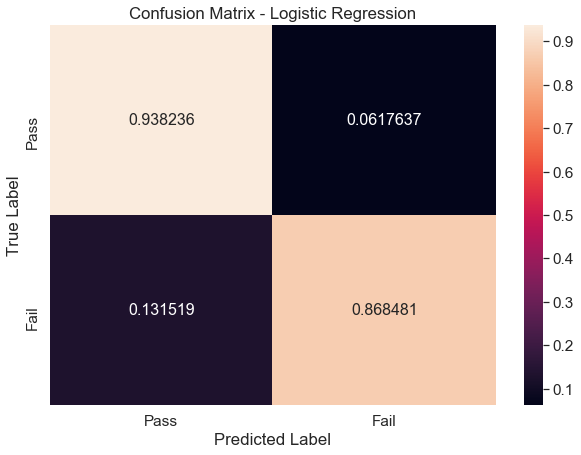

In [19]:
#Confusion Matrix to Visualize the Predictions



cf_matrix = confusion_matrix(y, best_logit_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Pass", 1: "Fail"})
df_cm.index = ["Pass", "Fail"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Validation Metrics

**Hint**: Try writing a for loop to use [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to check for accuracy, precision, recall and f1 across all of your models.

### Model 1 - Support Vector Machine Validation Metrics

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, fscore, support = precision_recall_fscore_support(y, best_svm_pred, average='binary')
accuracy = accuracy_score(y, best_svm_pred)

print ("Validation Metrics are", precision, recall, fscore, support, accuracy)

### Model 2 - Decision Tree Validation Metrics

In [20]:
accuracy_scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
scorers = {'accuracy': accuracy_scorer, 'f1': f1_scorer, 'precision': precision_scorer, 'recall': recall_scorer}
for scorer in scorers:
    cv_scores = cross_val_score(cart, X, y, cv=5, scoring=scorer)
    print(scorer, np.mean(cv_scores))

accuracy 0.9218861986675204
f1 0.8315568279494039
precision 0.7359607860700776
recall 0.9565975882886709


### Model 3 - Logistic Regression Validation Metrics

In [21]:
#Validation Metrics for Logistic Regression

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y, best_logit_pred)
precision, recall, fscore, support = precision_recall_fscore_support(y, best_logit_pred, average = "binary")
print ("Accuracy is", accuracy)
print ("Precision is", precision) 
print ("Recall is", recall) 
print ("Fscore is", fscore)

Accuracy is 0.9241721638038012
Precision is 0.780267753201397
Recall is 0.8684807256235828
Fscore is 0.8220144105472942


**Model Selection and Metric Prioritizion for Conducting Predictive Auditing:** In the above analysis, we see similar accuracy scores between the logistic regression and decision tree models. However, while the logistic regression model has a slighltly higher precision score, the desision tree recall and F score are higher. As a reminder, the recall metric takes into account all positive class members in the dataset--in our case, establishments that fail inspection--and tells us how many of the observations were successfully predicted as positive. Further, a slightly lower precision score may not be as consequential--incorrectly flagging a restaurant as failing (false positive) might trigger an inspection but it would not necessarily put anyone at risk in the way that a false negative might. We can also use the F score metric to balance this tradeoff as both the precision and recall metrics contribute to determining the score. Given the context of the problem, we will move forward with the decision tree model and F1 score metric for conducting predictive auditing.  

## Policy Simulation

### Interpretable Machine Learning

**Hint**: Use tools like feature importance plots and coefficient plots

### Feature Importance Plot

Using a feature importance plot, we assign scores to the features in our decision tree model based on their impact in prediciting our target variable. Below we see that the 'seriousCount' feature appears to be very important in predicting whether an establishment passes or fails their food inspection. 

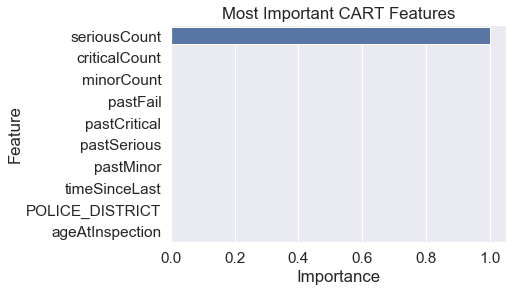

In [22]:
# feature important
cart_data = pd.concat([pd.DataFrame(X.columns), pd.Series(cart.feature_importances_)], axis=1)
cart_data.columns = ['Feature', 'Importance']

sns.barplot(x="Importance", y="Feature", data=cart_data.nlargest(10, 'Importance')).set_title("Most Important CART Features")
plt.show()

### Coefficients with the largest absolute value: 
The plot below displays the logit coeffiecients with largest absolute value. We can use this to visualize the top ten features contributing to our logistic regression model. Similar to the feature importance plot, we see that 'seriousCount' has a big impact on our model. 

In [23]:
#Dataframe with the features and the logit coefficients 
logit_data = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(logit_grid.best_estimator_.coef_))], axis = 1)
logit_data.columns = ['Feature', 'Coefficient']
logit_data['abs_coef'] = abs(logit_data['Coefficient'])

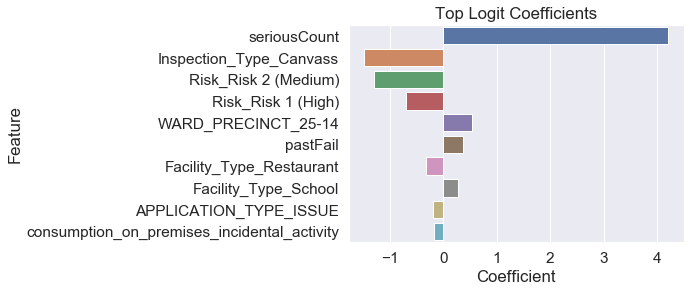

In [24]:
#Plotting the 10 coefficients with the largest absolute value
sns.barplot(x="Coefficient", y="Feature", data=logit_data.nlargest(10, 'abs_coef')).set_title("Top Logit Coefficients")
plt.show()

## Prioritize Audits

**Hint**: Look up the [`.predict()`](https://www.kite.com/python/docs/sklearn.linear_model.SGDRegressor.predict), [`.predict_proba()`](https://www.kite.com/python/docs/sklearn.linear_model.LogisticRegression.predict_proba), and [`.sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) methods. Then: 
1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities. 
2. Order your audits by their probability of detecting a "Fail" score
3. Plot your distribution of pass/fail among the first 1000 observations in the dataset
4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1000 observations at random

In [25]:
# Predict probabilities
cart_prob = cart.predict_proba(X)

# keep probabilities for the positive outcome only (fail)
cart_prob_fail = cart_prob[:, 1]

# Predict outcome
cart_outcome = cart.predict(X)
print(cart_outcome)

# Order audit by probability of detecting a "Fail" score
cart_prob_order = sorted(cart_prob_fail, reverse = True)

[0 0 1 ... 1 0 0]


In [26]:
# Merge dataset
chicago_inspections_2011_to_2013["predicted_prob_fail"] = cart_prob_fail
chicago_inspections_2011_to_2013["predicted_outcome"] = cart_outcome

# Sort by probability failing
chicago_inspections_2011_to_2013.sort_values(by = "predicted_prob_fail", ascending = False)

# Validation Metrics between result and predicted outcome
accuracy = accuracy_score(y, cart_outcome)
precision, recall, fscore, support = precision_recall_fscore_support(y, cart_outcome, average = "binary")
print ("Accuracy is", accuracy)
print ("Precision is", precision) 
print ("Recall is", recall) 
print ("Fscore is", fscore)
print ("Support is", support)

Accuracy is 0.9218862255894456
Precision is 0.735491905354919
Recall is 0.9565921606737934
Fscore is 0.8315967333145593
Support is None


In [27]:
# replace results  - pass with conditions, replace with pass
data_new = chicago_inspections_2011_to_2013.replace({'Pass w/ Conditions': 'Pass'})

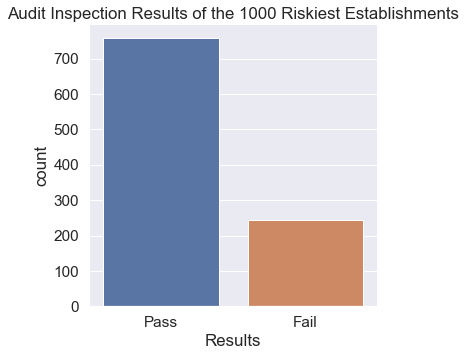

In [28]:
# Plot distribution of pass/fail among the first 1000 observations in the dataset
sns.catplot(data = data_new.iloc[0:1000], x = "Results", kind = "count")
plt.title("Audit Inspection Results of the 1000 Riskiest Establishments")
plt.show()

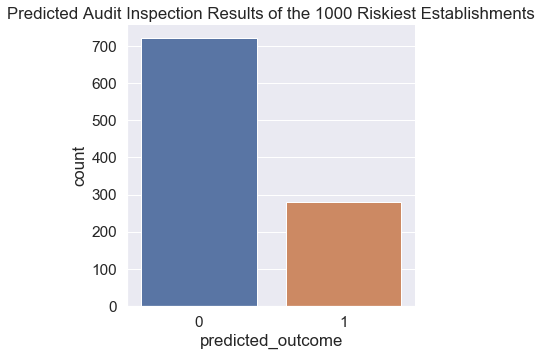

In [29]:
# Plot predicted outcome - first 1000 obs predicted pass/fail 
chicago_inspections_2011_to_2013.loc[chicago_inspections_2011_to_2013["predicted_outcome"] == 0]
chicago_inspections_2011_to_2013.loc[chicago_inspections_2011_to_2013["predicted_outcome"] == 1]
                                     
sns.catplot(data = chicago_inspections_2011_to_2013.iloc[0:1000], x = "predicted_outcome", kind = "count")
plt.title("Predicted Audit Inspection Results of the 1000 Riskiest Establishments")
plt.show()

### Predict on Data with Unseen Labels

We think that f1 score is the most suitable metric for this policy problem, since both false positives and false negatives would have undesirable impact on the establishments (false positives) and consumers (false negatives). Accuracy is not suitable here since the labels are unevenly distributed.

In [30]:
# Fill in the code below with the X data you used for training
# predicted results
y_hat_unseen = cart.predict(X_unseen)

In [31]:
with open('predictions.csv', 'w') as f:
    f.write('Inspection_ID,Results\n')
    for inspection_id, y_hat in zip(X_unseen_inspection_ids, y_hat_unseen):
        f.write('{},{}\n'.format(inspection_id, 'Fail' if y_hat == 1 else 'Pass'))

## Discussion Questions

**Why do we need metrics beyond accuracy when using machine learning in the social sciences and public policy?**

While assessing the accuracy of our machine learning models is certainly an important objective, we can see that in real-world contexts, additional metrics may offer a more nuanced perspective on the performance of our models. With regard to this report and food inspections, the recall metric takes into account all positive class members in the dataset--those establishments that fail food inspection--and tells us how many of the observations were successfully predicted as positive. As you can see in our model, the recall rate of our CART model is nearly 96 percent. While the precision rate is slightly lower, this metric doesn't seem as consequential. That is, incorrectly flagging a restaurant as failing (false positive) might trigger an inspection but it wouldn't necessarily put anyone at risk in the way that a false negative might. However, we could imagine a scenario where we might look to a precision metric. With the exception of COVID-19, in the medical community, precision might be more important; for example, incorrectly diagnosing a patient with cancer (false positive) might expose them to harmful treatment, like chemotherapy, which can be dangerous if cancer isn’t present. Similarly, precision is crucial to predictive models in policing and criminal justice in which false positives in cases like correctly identifying a criminal or the probability of an inmate receiving parole have costly implications. And for research questions where it makes sense to take both recall and precision into consideration, the F score metric can help balance this tradeoff as both the precision and recall metrics contribute to determining the score. The F-Score is a better measure of the incorrectly identified cases making the F-score crucial for the false negatives and false positives.

**Imagine that establishments learned about the algorithm being used to determine who gets audited and they started adjusting their behavior (and changing certain key features about themselves that were important for the prediction) to avoid detection. How could policymakers address this interplay between algorithmic decision making and real world behavior?**

It is important that we fully grasp and understand the features we include in machine learning  algorithms to ensure we include the key features that are both important to prediction and also substantively meaningful. For example, suppose we had a highly predictive feature such as the frequency that utensils and dishes are washed per day. If learning about this feature’s importance induces establishments to increase their sanitation routines in their efforts to avoid detection, then it would ostensibly benefit the overall food safety for the general public. If, on the other hand, we found that large sink water usage is indicative of improved sanitation, it might not be a good idea to overly rely on the feature, as restaurants could evade detection by increasing water usage without actually cleaning the utensils. As social scientists and policy makers, it is key we recognize and seek to reconcile the tension between intent and impact in predictive modeling and algorithmic decision making. In our model, the intent is to adapt dangerous or unsanitary environments. However, the impact may be establishments making minor adjustments just to keep from being flagged for audit without actually creating more sanitary workplaces, as highlighted in our aforementioned example of restaurants evading detection by increasing water usage without actually cleaning the utensils. Thus, it's imperative that we consider not only the aim of the predictive model, but also the implications of its utilization to better anticipate frictions between algorithmic decision making and real world behavior. 